# Using R to Explore and Visualize Initial Data
Spark is a heavy-duty tool. Let's begin with some lightweight analyses to highlight where to dig in.

Note that this leverages the analyses prepped by the WaPo team here: https://wpinvestigative.github.io/arcos/index.html

In [3]:
#prepare the libraries:
library(arcos)
library(knitr)
library(tigris)
library(viridis)
library(tidyverse)
library(scales)
library(plyr)
library(dplyr)

## Pills by County, by Year
In this section, we will fire up the ARCOS API to begin our search and highlight interest areas:



|BUYER_COUNTY |BUYER_STATE | year| count| DOSAGE_UNIT|countyfips |
|:------------|:-----------|----:|-----:|-----------:|:----------|
|BELKNAP      |NH          | 2006|  4095|     1542020|33001      |
|BELKNAP      |NH          | 2007|  4916|     1943260|33001      |
|BELKNAP      |NH          | 2008|  5025|     2108300|33001      |
|BELKNAP      |NH          | 2009|  5193|     2175540|33001      |
|BELKNAP      |NH          | 2010|  5647|     2302260|33001      |
|BELKNAP      |NH          | 2011|  5447|     2266640|33001      |

  |======================================================================| 100%


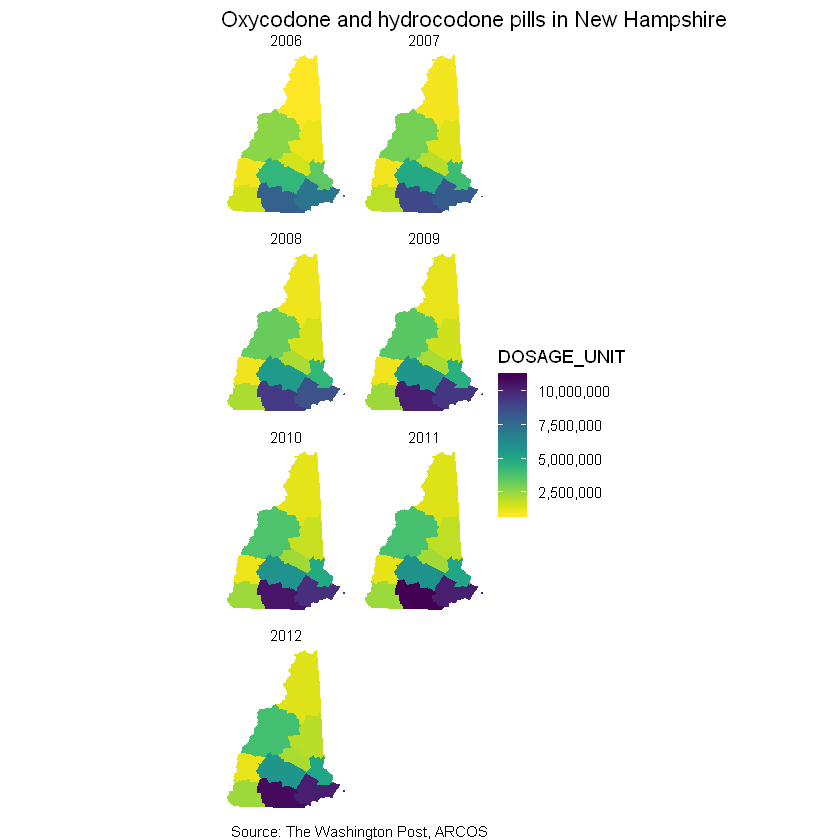

In [3]:
#using the arcos API to get summarized county data:
nh <- summarized_county_annual(state="NH", key="WaPo")
kable(head(nh))
## Set the option for shapefiles to load with sf
options(tigris_class = "sf")
## Function to download county shapefiles in New Hampshire
nh_shape <- counties(state="NH", cb=T)
## Join the county dosage data we pulled
nh<- left_join(nh, nh_shape, by=c("countyfips"="GEOID"))

# Mapping with ggplot2, sf, and viridis
nh %>%
  ggplot(aes(geometry=geometry, fill = DOSAGE_UNIT, color = DOSAGE_UNIT)) +
  facet_wrap(~year, ncol=2) +
  geom_sf() +
  coord_sf(crs = 26915) + 
  scale_fill_viridis(direction=-1, label = comma) +
  scale_color_viridis(direction=-1, label = comma) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) +
  labs(title="Oxycodone and hydrocodone pills in New Hampshire", caption="Source: The Washington Post, ARCOS")

## Initial Takeaways:
It looks like the most pills are distributed in Southern NH. However, we suspect it's also the most populous part of NH, and may or may not be indicative of diversion of prescription meds to the black market.

Clearly, more pills have been distributed over time, seemingly in every county.

Next, let's try to normalize this by population:

## Pills Per Capita by County
Normalized for Population:

Joining, by = c("year", "countyfips")


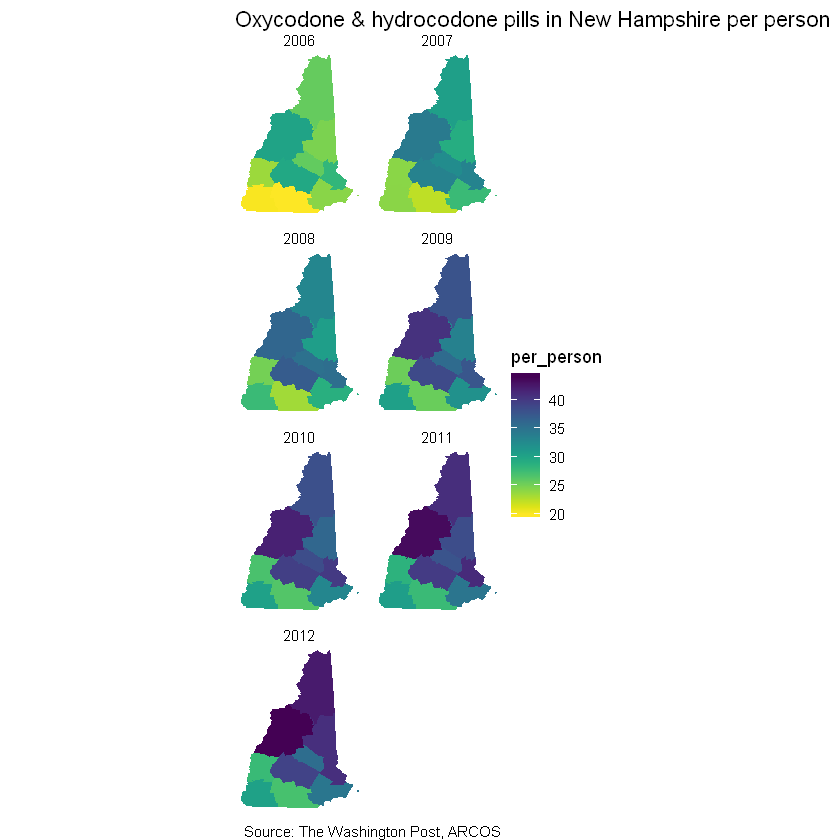

In [4]:
#pull in population data from WaPo's helpful API
population <- county_population(state="NH", key="WaPo") %>% 
  # isolate the columns so it doesn't conflict in a join (there are doubles, that's why)
  select(countyfips, year, population)

left_join(nh, population) %>% 
  mutate(per_person=DOSAGE_UNIT/population) %>%
  ggplot(aes(geometry=geometry, fill = per_person, color = per_person)) +
  facet_wrap(~year, ncol=2) +
  geom_sf() +
  coord_sf(crs = 26915) + 
  scale_fill_viridis(direction=-1, label = comma) +
  scale_color_viridis(direction=-1, label = comma) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) +
  labs(title="Oxycodone & hydrocodone pills in New Hampshire per person", caption="Source: The Washington Post, ARCOS")


## Takeaways:
This seems to tell another story! It looks like the northern, more rural counties, experienced a much greater per-capita change over time.



## Calculate change in pills per person over time:
Which county had the greatest change in pills per capita in this period?

In [7]:
#let's bring in population more permanently
nh <- left_join(nh, population)

#calculate pills per person
nh$pills_per = nh$DOSAGE_UNIT/nh$population

ddply(nh, .(BUYER_COUNTY), summarise, mean=mean(pills_per), min=min(pills_per), max=max(pills_per), maxdiff = max(pills_per)-min(pills_per))


Joining, by = c("year", "countyfips", "population")


BUYER_COUNTY mean     min      max      maxdiff  
1  BELKNAP      34.27657 25.65544 38.28040 12.624967
2  CARROLL      33.21827 24.62011 40.70308 16.082979
3  CHESHIRE     27.55435 20.03657 30.47373 10.437162
4  COOS         35.36408 25.51902 42.17571 16.656696
5  GRAFTON      38.49998 29.98372 43.88256 13.898842
6  HILLSBOROUGH 24.47257 19.86496 27.54544  7.680484
7  MERRIMACK    36.65994 29.47486 39.73759 10.262727
8  ROCKINGHAM   30.59175 24.09055 34.60476 10.514206
9  STRAFFORD    36.51739 28.06228 41.10330 13.041019
10 SULLIVAN     25.76191 23.40308 28.39548  4.992404

ERROR: Error in SUM(nh$DOSAGE_UNIT): could not find function "SUM"


## Conclusion: Rural Counties experienced most volume per capita change overall.
As we can see, the initial images were **misleading**! Coos and Carroll counties experienced the most per capita change in this 7 year period, **not** the counties nearest Boston/Massachusetts.

Next, we use WaPo's API to find which pharmacies were responsible for the greatest per capita pill distrubition.

## Identify potential "Problem Pharmacies"
The intent here is to identify which pharmacies deserve a closer look into their practices, since high per capita pill concentrations **could be an indicator of diversion to black market**.

In [34]:
#adapted from here:
#https://wpinvestigative.github.io/arcos/articles/per-capita-pharmacies.html

packages <- c("tidyverse", "jsonlite", "knitr", "geofacet", "scales", "data.table", "vroom","formattable")
if (length(setdiff(packages, rownames(installed.packages()))) > 0)
  {install.packages(setdiff(packages, rownames(installed.packages())), repos = "http://cran.us.r-project.org")}

library(tidyverse)
library(lubridate)
library(data.table)
library(formattable)
library(vroom)
library(stringr)
library(scales)
library(knitr)

In [52]:
new_hampshire <- total_pharmacies_state(state="NH", key="WaPo")

# kable(head(new_hampshire))
#need to rerun this, different agg:
population <- county_population(state="NH", key="WaPo")

#had to rewrite this bit:
population <- population %>%
  group_by(BUYER_COUNTY, BUYER_STATE, countyfips) %>%
  summarise_at(vars(population), funs(mean(., na.rm=TRUE)))

population <- rename(population, replace = c("BUYER_COUNTY"="buyer_county"))
population <- rename(population, replace = c("BUYER_STATE"="buyer_state"))
population <- rename(population, replace = c("population"="average_population"))

## Join the data
nh_joined <- left_join(new_hampshire, population)
#> Joining, by = c("buyer_state", "buyer_county")

#want to get pills per person per year:
nh_joined <- nh_joined %>% 
  mutate(per_person=total_dosage_unit/average_population/7)

# kable(head(nh_joined))
## Get a list of addresses because it includes BUYER_BUS_ACT information
pharmacy_list <- buyer_addresses(state="NH", key="WaPo")

# We just want the BUYER_BUS_ACT to tell if these are practitioners are retail pharmacies
# This will help us filter out the appropriate pharmacies

pharmacy_list <- pharmacy_list %>% 
  select(buyer_dea_no=BUYER_DEA_NO, BUYER_BUS_ACT)

# Join to the original data set
nh_joined <- left_join(nh_joined, pharmacy_list)
# Filter the data so we only have retail and chain pharmacies
nh_joined <- nh_joined %>% 
  filter(BUYER_BUS_ACT=="RETAIL PHARMACY" | BUYER_BUS_ACT=="CHAIN PHARMACY")

# Just in case, let's get the BUYER_DEA_NO of pharmacies that aren't really pharmacies
not_pharms <- not_pharmacies(key="WaPo") %>% pull(BUYER_DEA_NO)

# 
#what_we_omit <- nh_joined %>% 
#  filter(buyer_dea_no %in% not_pharms)

#kable(head(what_we_omit))

# Filter those out, too, if they're in there
nh_joined <- nh_joined %>% 
  filter(!buyer_dea_no %in% not_pharms)

# clean up column names so we can make a pretty table
nh_joined <- nh_joined %>% 
  select(Pharmacy=buyer_name, City=buyer_city, County=buyer_county, `County population`=average_population,
         Pills=total_dosage_unit, `Pills per person`=per_person) %>% 
  mutate(`County population`=round(`County population`),
         `Pills per person`=round(`Pills per person`, 1)) %>% 
  arrange(desc(`Pills per person`)) %>% 
  slice(1:100)

# Create some custome colors
customGreen0 = "#DeF7E9"
customGreen = "#71CA97"
customRed = "#ff7f7f"

# produce a table
nh_joined %>% 
  formattable(align=c("l", "l", "l", "r", "r", "r"),
              list(Pharmacy = formatter("span", style = ~ style(color="grey", font.weight = "bold")),
                   Pills=color_tile(customGreen0, customGreen),
                   `Pills per person` = normalize_bar(customRed)
              ))

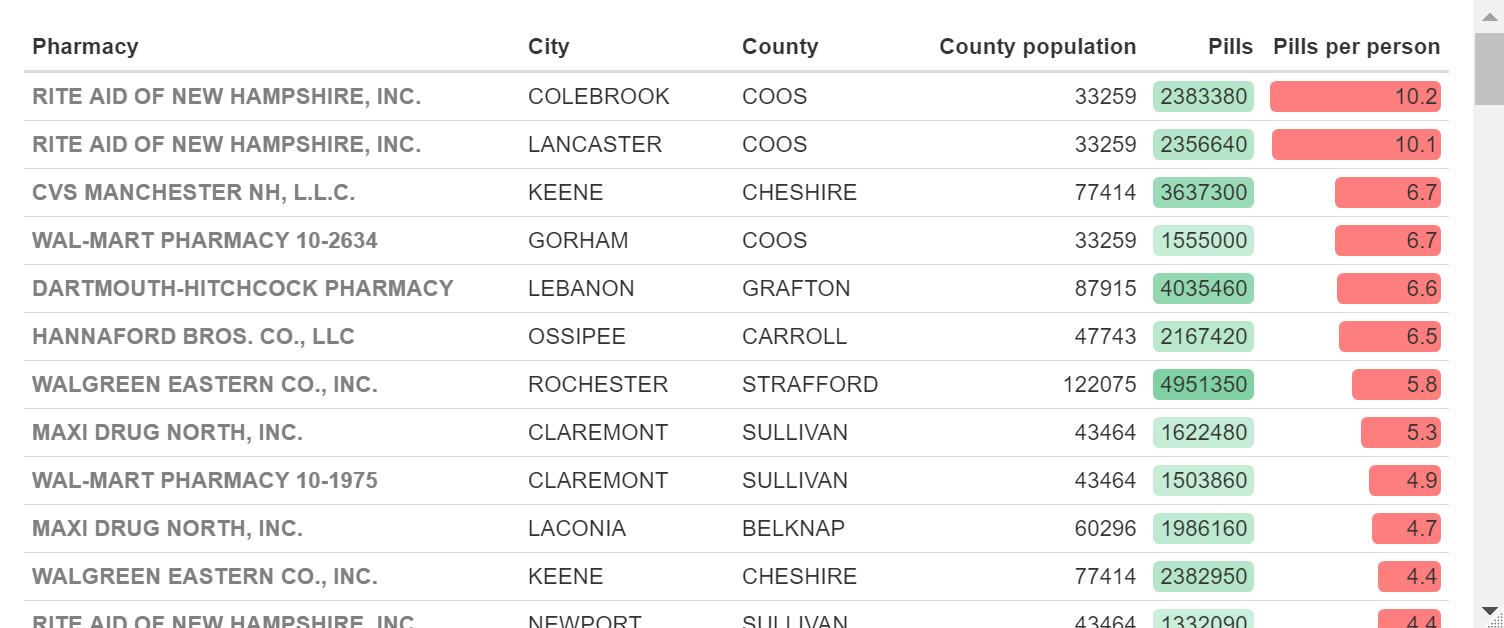

In [53]:
# nil

## Conclusion: These pharmacies have high pill counts relative to their local populations.
This could be a jumping-off point for further investigation.

Note - we did a lot of work to omit non-pharmacies (e.g., hospital pharmacies, which might obviously have relatively high pain medication dispensing). But as we can see, Dartmouth-Hitchcock, a large university hospital in a rural setting, still made it on our list.

The fact that there are several pharmacies ahead of it on this "hit-list" should raise eyebrows.

In [ ]:
# library("IRdisplay")
# display_png(file="Rplot01.png")